# Sharpe Ratio and Portfolio Values

* Before, we were doing analysis of individual tickers, now we shift our attention to understanding of a portfolio of mutiple stocks.
* A portfolio is a set of allocations in a variety of securities.
* The Sharpe ratio takes this into consideration and is an important metric for evaluating the performance of assets or a portfolio. 
* This metric provides a standardized way of measuring how well your investments or strategies are performing, and how it does so is simple to understand.

### The structure of the program is as follows:

* use api to read-in crypto price data
* define functions to generate mean daily returns and a covariance matrix for our coins
* define function to randomly weight proportions of each coin in a portfolio and calculate the portfolio's risk-adjusted return (Sharpe ratio) and variance over a specified period of time
* use Monte-Carlo method to find weighting of coins to maximize Sharpe ratio and minimize volatility
* plot all portfolios with stars on portfolios with highest Sharpe ratio and lowest volatility

### Step 0: Import Librariees


In [1]:
import time
import pandas_datareader.data as pdr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#plt.style.use('ggplot')

### Step 1: Get Stock Data 

* First we'll use the yahoo finance API to get stock price data for four coins: bitcoin, ethereum, litecoin & XRP.

In [2]:
stocks = ['BTC-USD', 'ETH-USD', 'LTC-USD','XRP-USD']

In [3]:
def get_data(tickers, start_date, end_date):
    
    """Read in daily price(adjusted close) of asset from CSV files for a given set of dates."""
    
    # download daily price data for each of the stocks in the portfolio
    df = pdr.get_data_yahoo(stocks, start=start_date, end = end_date)['Adj Close']
    df.sort_index(inplace = True)
    
    return df

In [4]:
#Start and End Dates

crypto_prices = get_data(stocks, '01/01/2020', '01/01/2021' )
print(crypto_prices.head())

Symbols         BTC-USD     ETH-USD    LTC-USD   XRP-USD
Date                                                    
2020-01-01  7200.174316  130.802002  42.017719  0.192667
2020-01-02  6985.470215  127.410179  39.823013  0.188043
2020-01-03  7344.884277  134.171707  42.415573  0.193521
2020-01-04  7410.656738  135.069366  43.326607  0.194355
2020-01-05  7411.317383  136.276779  43.553207  0.195537


In [5]:
crypto_prices.head()

Symbols,BTC-USD,ETH-USD,LTC-USD,XRP-USD
Date,,,,
2020-01-01,7200.174316,130.802002,42.017719,0.192667
2020-01-02,6985.470215,127.410179,39.823013,0.188043
2020-01-03,7344.884277,134.171707,42.415573,0.193521
2020-01-04,7410.656738,135.069366,43.326607,0.194355
2020-01-05,7411.317383,136.276779,43.553207,0.195537


Next we'll define a function for calculating daily returns for our coins 

In [6]:
def calc_daily_returns(df):
    return (df.pct_change())

In [9]:
crypto_daily_rets = calc_daily_returns(crypto_prices)
print(crypto_daily_rets.head())

Symbols      BTC-USD   ETH-USD   LTC-USD   XRP-USD
Date                                              
2020-01-01       NaN       NaN       NaN       NaN
2020-01-02 -0.029819 -0.025931 -0.052233 -0.024000
2020-01-03  0.051452  0.053069  0.065102  0.029132
2020-01-04  0.008955  0.006690  0.021479  0.004310
2020-01-05  0.000089  0.008939  0.005230  0.006082


note the first day will be a null value, cause no day comes before it

Define a function for calculating mean daily returns for our coins

In [14]:
def calc_mean_daily_returns(daily_returns):
    return (daily_returns.mean())

In [15]:
crypto_mean_daily_rets = calc_mean_daily_returns(crypto_daily_rets)
print(crypto_mean_daily_rets.head())

Symbols
BTC-USD    0.004911
ETH-USD    0.006234
LTC-USD    0.004627
XRP-USD    0.002266
dtype: float64


Define a function for creating covariance matrices

In [16]:
def create_covariance_matrix(daily_returns):
    return daily_returns.cov()

In [17]:
crypto_cov_matrix = create_covariance_matrix(crypto_daily_rets)
print(crypto_cov_matrix)

Symbols   BTC-USD   ETH-USD   LTC-USD   XRP-USD
Symbols                                        
BTC-USD  0.001456  0.001589  0.001639  0.001260
ETH-USD  0.001589  0.002467  0.002161  0.001990
LTC-USD  0.001639  0.002161  0.002643  0.002026
XRP-USD  0.001260  0.001990  0.002026  0.003692


Below is a function to calculate and return a dataframe with portfolio returns, standard deviations, and sharpe ratios for a specified number of randomly weighted portfolios consisting of our four coins.

In [18]:
def create_results_dataframe(tickers, number_portfolios, mean_daily_returns, cov_matrix):
    results_temp = np.zeros((4 + len(tickers) - 1, number_portfolios))

    for i in range(number_portfolios):
        # select random weights for portfolio holdings
        weights = np.array(np.random.random(4))
        
        # rebalance weights to sum to 1
        weights /= np.sum(weights)

        # calculate portfolio return and volatility
        portfolio_return = np.sum(mean_daily_returns * weights) * 252
        portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)

        # 3 month T-Bill yield used as risk free rate of return
        risk_free_return = 0.0139

        # store results in results array
        results_temp[0, i] = portfolio_return
        results_temp[1, i] = portfolio_std_dev
        
        # store Sharpe Ratio (return / volatility) - risk free rate element excluded for simplicity
        results_temp[2, i] = (results_temp[0, i] - risk_free_return) / results_temp[1, i]
        
        # iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_temp[j + 3, i] = weights[j]

    # convert results array to Pandas DataFrame
    results_df = pd.DataFrame(results_temp.T, columns=['ret', 'stdev', 'sharpe', tickers[0], 
                                                       tickers[1], tickers[2], tickers[3]])
    
    return results_df

In [19]:
crypto_results = create_results_dataframe(stocks, 10000, crypto_mean_daily_rets, crypto_cov_matrix)
print(crypto_results.head())

        ret     stdev    sharpe   BTC-USD   ETH-USD   LTC-USD   XRP-USD
0  1.113264  0.694164  1.583724  0.316063  0.249496  0.138062  0.296379
1  1.026612  0.694088  1.459054  0.372434  0.153430  0.090725  0.383411
2  1.222922  0.656759  1.840890  0.522799  0.147665  0.261887  0.067649
3  1.093955  0.696349  1.551025  0.324579  0.062534  0.410302  0.202586
4  1.027640  0.745436  1.359929  0.127506  0.132522  0.402019  0.337954


Define a function to find the portfolio with the highest sharpe ratio

In [20]:
def max_sharpe_ratio(results_df):
    """locate portfolio with highest Sharpe Ratio"""
    return results_df.iloc[results_df['sharpe'].idxmax()]

In [21]:
crypto_max_sharpe_portfolio = max_sharpe_ratio(crypto_results)
print(crypto_max_sharpe_portfolio)

ret        1.352950
stdev      0.646834
sharpe     2.070160
BTC-USD    0.618977
ETH-USD    0.354771
LTC-USD    0.024578
XRP-USD    0.001674
Name: 9767, dtype: float64


* Now, the basic purpose of the Sharpe ratio is to allow an investor to analyze how much greater a return he or she is obtaining in relation to the level of additional risk taken to generate that return.

* Generally a sharpe ratio greater than one is considered acceptable to good by investors, depending on what their kind of risk tolerances, but more importantly, depending on who their actual customers are.

* A ratio higher than two is usually rated as very good and the ratio of three or higher is considered to be excellent.

Define a function to find the portfolio with the lowest volatility

In [22]:
def min_volatility(results_df):
    """locate portfolio with lowest volatility"""
    return results_df.iloc[results_df['stdev'].idxmin()]

In [23]:
crypto_min_vol_portfolio = min_volatility(crypto_results)
print(crypto_min_vol_portfolio)

ret        1.200575
stdev      0.607158
sharpe     1.954475
BTC-USD    0.871553
ETH-USD    0.042220
LTC-USD    0.010801
XRP-USD    0.075426
Name: 9662, dtype: float64


* Write func to plot all of the different portfolios consisting of different mixtures (weights) for our four coins
* Also, plot the portfolio with teh highest Sharpe with a red star and the lowest volatility with a green star
* Lastly, plot a color bar showing the sharpe ratio for all portfolios

In [31]:
def plot_graph(results_df, max_sharpe_port, min_vol_port):
    ax = results_df.plot(kind= 'scatter', x = 'stdev', y='ret', s = 30, 
                         c=results_df.sharpe, cmap='RdYlBu',edgecolors='.1', figsize=(20,10))
    ax.grid(False, color='w', linestyle='-', linewidth=1)
    ax.set_facecolor('.5')
    ax.set_xlabel('Volatility')
    ax.set_ylabel('Returns')
    ax.tick_params(labelsize = 14)

    # # plot red star to highlight position of portfolio with highest Sharpe Ratio
    ax.scatter(max_sharpe_port[1], max_sharpe_port[0], marker=(5, 1, 0), color='r', s=1000)
    # # plot green star to highlight position of minimum variance portfolio
    ax.scatter(min_vol_port[1], min_vol_port[0], marker=(5, 1, 0), color='g', s=1000)

<ipython-input-31-48ef04ff4e9d>:4: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.grid(False, color='w', linestyle='-', linewidth=1)


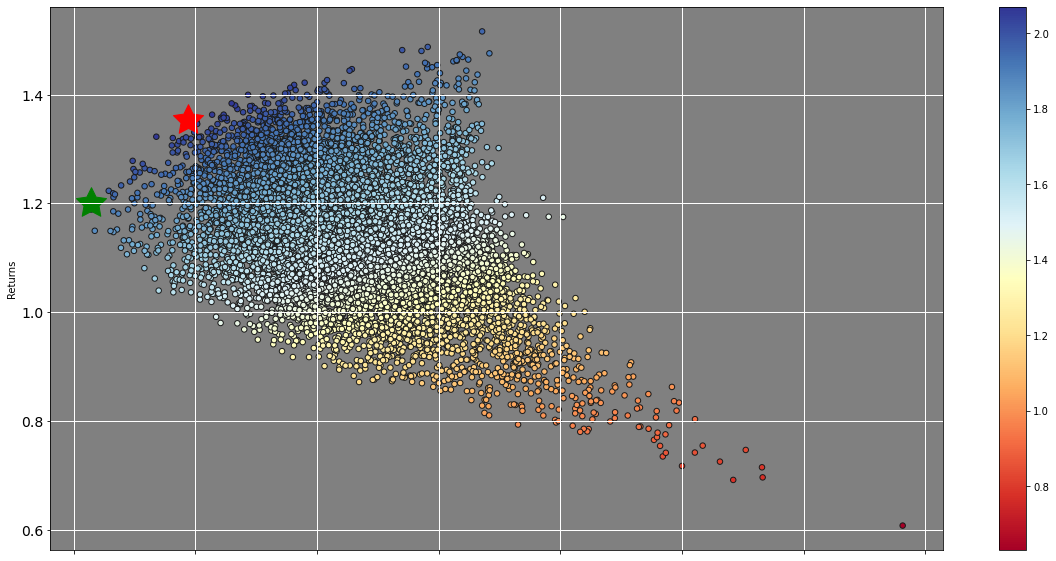

In [50]:
plot_graph(crypto_results, crypto_max_sharpe_portfolio, crypto_min_vol_portfolio)
plt.show();

# Mathematical Optimization

There are much better ways to find good allocation weights than just guess and check! We can use optimization functions to find the ideal weights mathematically!

### Functionalize Return and SR operations

In [33]:
def get_ret_vol_sr(weights):
    """
    Takes in weights, returns array or return,volatility, sharpe ratio
    """
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])

In [34]:
from scipy.optimize import minimize

In [35]:
def neg_sharpe(weights):
    return  get_ret_vol_sr(weights)[2] * -1

In [36]:
# Contraints
def check_sum(weights):
    '''
    Returns 0 if sum of weights is 1.0
    '''
    return np.sum(weights) - 1

In [37]:
# By convention of minimize function it should be a function that returns zero for conditions
cons = ({'type':'eq','fun': check_sum})

In [38]:
# 0-1 bounds for each weight
bounds = ((0, 1), (0, 1), (0, 1), (0, 1))

In [39]:
# Initial Guess (equal distribution)
init_guess = [0.25,0.25,0.25,0.25]

In [42]:
# Log Ret 

log_ret = np.log(crypto_prices/crypto_prices.shift(1))
log_ret.head()

Symbols,BTC-USD,ETH-USD,LTC-USD,XRP-USD
Date,,,,
2020-01-01,NaN,NaN,NaN,NaN
2020-01-02,-0.030273,-0.026273,-0.053646,-0.024293
2020-01-03,0.050172,0.051709,0.063071,0.028715
2020-01-04,0.008915,0.006668,0.021251,0.004300
2020-01-05,0.000089,0.008899,0.005216,0.006063


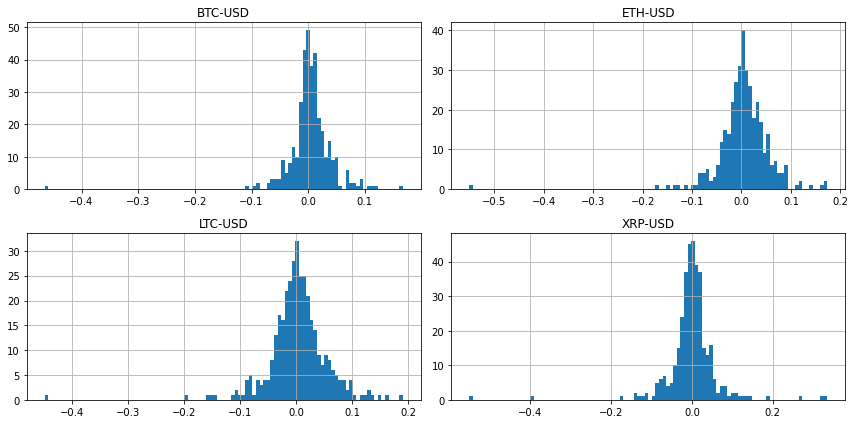

In [44]:
log_ret.hist(bins=100,figsize=(12,6));
plt.tight_layout()

In [45]:
log_ret.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Symbols,,,,,,,,
BTC-USD,363.0,0.004120,0.040493,-0.464730,-0.009415,0.002919,0.018352,0.167104
ETH-USD,363.0,0.004900,0.052639,-0.550732,-0.015946,0.005691,0.029418,0.173452
LTC-USD,363.0,0.003255,0.052943,-0.449062,-0.018078,0.002725,0.026291,0.190930
XRP-USD,363.0,0.000386,0.062167,-0.550503,-0.018405,0.002028,0.019416,0.334399


In [43]:
# Sequential Least SQuares Programming (SLSQP).
opt_results = minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)

In [46]:
opt_results

     fun: -1.623338883019848
     jac: array([-3.05771828e-05,  1.64493918e-04,  5.62317833e-01,  1.31425171e+00])
 message: 'Optimization terminated successfully'
    nfev: 30
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([8.43095533e-01, 1.56904467e-01, 3.03576608e-16, 0.00000000e+00])

In [47]:
opt_results.x

array([8.43095533e-01, 1.56904467e-01, 3.03576608e-16, 0.00000000e+00])

In [48]:
get_ret_vol_sr(opt_results.x)

array([1.06909121, 0.65857549, 1.62333888])